This cell imports all the required libraries and modules for the tasks. It brings in matplotlib for plotting, numpy for numerical operations, and tensorflow.keras for building and training the neural network. It also imports linalg from scipy to handle PCA-related linear algebra. The print statement shows the TensorFlow version being used.

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras

import matplotlib.style
import matplotlib as mpl

from scipy import linalg

print(tf.__version__)

2.18.0


the MNIST dataset is loaded using keras.datasets.mnist, which returns two tuples: (train_images, train_labels) and (test_images, test_labels). The train_images are then normalized by dividing by 255.0, converting pixel intensities into a [0,1] range. Reshaped the 60,000 training images into a 2D array X of shape (60000, 784), where each row is a single image’s pixels. Also calculated the mean mu of the training set along each column. Subtracting this mean from each image yields a centered dataset x. Next, rho is computed as the covariance matrix of x, crucial for PCA. Finally, the cell computes its eigenvalues and eigenvectors using linalg.eigh, which is appropriate for symmetric matrices like covariance. Flipping the resulting eigenvalues and eigenvectors ensures the largest eigenvalues come first—this allows it to access the “top” principal components easily.

In [83]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images=train_images/255.0

X=np.reshape(train_images,(60000,784))
print("X.shape:",np.shape(X))

mu=np.mean(X,axis=0)
x=X-mu
rho=np.cov(x,rowvar=False)
print("rho.shape:",np.shape(rho))


vals,vecs=linalg.eigh(rho)
print("vecs.shape:",np.shape(vecs))
print("vals.shape:",np.shape(vals))

vecs=np.flip(vecs)
vals=np.flip(vals)

X.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


This cell defines a function create_model that returns a Keras Sequential model suitable for classifying MNIST digits. It sets up an input layer expecting an image of shape (28, 28), flattens it into a single vector of 784 features, then applies a Dense layer of 128 neurons with ReLU activation, and finally outputs 10 logits. The model is compiled with Adam optimization, using sparse categorical crossentropy as the loss function and accuracy as the metric.

In [84]:
def create_model(input_shape=(28,28)):
  """
  Creates and compiles a Keras Sequential model for MNIST digit classification.

  The model consists of:
    - Input layer: Expects images of shape `input_shape` (default: (28, 28)).
    - Flatten layer: Converts the image into a 1D vector.
    - Dense layer: 128 neurons with ReLU activation.
    - Output layer: 10 neurons (logits for 10 digit classes).

  Compiled with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric.

  Args:
    input_shape: Input image shape. Defaults to (28, 28) for MNIST.

  """

  model = keras.Sequential([
      keras.layers.Input(shape = input_shape),
      keras.layers.Flatten(),
      keras.layers.Dense(128,activation='relu'),
      keras.layers.Dense(10)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

  return model

This cell creates an instance of the model by calling create_model() and assign it to original_model. It then trains it on the original MNIST train_images. The model runs for 10 epochs with batches of size 100, reserving 10% of the training data for validation. This step fulfills the initial requirement to train a baseline neural network on MNIST. The trained model is used as a reference for comparing how PCA reconstructions affect accuracy. This cell also evaluates the freshly trained original_model on the untouched test set. The goal here is to measure baseline performance on the full-resolution MNIST data. The resulting accuracy, ~ 0.9765, confirms that the model is adequately trained and meets the first major task’s requirement of achieving acceptable performance on MNIST.



In [85]:
original_model=create_model()
original_model.fit(train_images, train_labels,batch_size=100, epochs=10, validation_split = 0.1)
test_loss, test_acc = original_model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8376 - loss: 0.6086 - val_accuracy: 0.9538 - val_loss: 0.1624
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9515 - loss: 0.1734 - val_accuracy: 0.9655 - val_loss: 0.1235
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9655 - loss: 0.1177 - val_accuracy: 0.9697 - val_loss: 0.0987
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9745 - loss: 0.0914 - val_accuracy: 0.9740 - val_loss: 0.0913
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9794 - loss: 0.0725 - val_accuracy: 0.9750 - val_loss: 0.0830
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9833 - loss: 0.0588 - val_accuracy: 0.9755 - val_loss: 0.0792
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9858 - loss: 0.0498 - val_accuracy: 0.9778 - val_loss: 0.0774
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9892 - loss: 0.0397 - val_accuracy: 0.

This cell defines evaluate_pca_accuracy, a function that evaluates a given model’s accuracy on test images reconstructed from varying numbers of PCA components. Internally, the function flattens and centers the test images, projects them onto the first N eigenvectors, reconstructs them back into 784 dimensions, and reshapes them to (28, 28). The model’s accuracy on each reconstruction is then computed via model.evaluate. The function ultimately prints the best number of components best_N and returns it along with the full list of accuracies. This is crucial for fulfilling the task of “using the N-best PCA components to make a new testing dataset and evaluating the original network without retraining.”

In [86]:
def evaluate_pca_accuracy(model, test_images, test_labels, mu, vecs, all_N_values):
    """
    Evaluates model accuracy on reconstructed test images using different numbers of PCA components.

    Args:
        model: The Keras model to evaluate.
        test_images: The original test images.
        test_labels: The test labels.
        mu: The mean of the training data (pre-calculated).
        vecs: The eigenvectors (principal components) (pre-calculated).
        all_N_values: A list of N values (number of components) to test.

    Returns:
        A tuple containing:
            - best_N: The N value that resulted in the highest accuracy.
            - accuracies: A list of accuracies corresponding to each N value.
    """

    accuracies = []

    test_images_flat = test_images.reshape(10000, 784)
    test_images_centered = test_images_flat - mu

    for N in all_N_values:

        test_images_pca = np.dot(test_images_centered, vecs[:, :N])


        test_images_reconstructed = np.dot(test_images_pca, vecs[:, :N].T) + mu


        test_images_reconstructed_reshaped = test_images_reconstructed.reshape((-1, 28, 28))

        _, accuracy = model.evaluate(test_images_reconstructed_reshaped, test_labels, verbose=0)
        accuracies.append(accuracy)

    best_N = all_N_values[np.argmax(accuracies)]
    print(f"Best N: {best_N} with accuracy={accuracies[np.argmax(accuracies)]:.4f}")

    return best_N, accuracies

This cell defines plot_pca_accuracy, which uses matplotlib to plot the accuracies returned by evaluate_pca_accuracy as a function of the number of components. It also draws a vertical line at the best_N value, labeling it on the chart. This gives a clear visual of how accuracy changes with PCA dimension reduction and identifies which value of N yields the highest accuracy. Such a plot directly addresses the part of the task where we must visualize N vs. test accuracy.

In [87]:
def plot_pca_accuracy(all_N_values, accuracies, best_N, title="MNIST Accuracy vs. Number of PCA Components"):
    """
    Plots the accuracy vs. the number of principal components.

    Args:
        all_N_values: A list of N values (number of components).
        accuracies: A list of accuracies corresponding to each N value.
        best_N: The N value that resulted in the highest accuracy.
        title: The title of the plot (optional).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(all_N_values, accuracies, marker='o', markersize=8, linestyle='-', linewidth=2, label='Test Accuracy')
    plt.axvline(best_N, color='r', linestyle='--', linewidth=2, label=f'Best N = {best_N}')
    plt.xlabel("Number of Principal Components (N)", fontsize=14)
    plt.ylabel("Test Accuracy", fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.show()

Here the cell specifies a list of interesting PCA component counts—ranging from as few as 1 to the full 784—and call evaluate_pca_accuracy(original_model, test_images, test_labels, mu, vecs, all_N_values). This uses the original model (trained on unaltered data) but tests how it performs on images reconstructed from fewer components. It then calls plot_pca_accuracy to generate a plot of the accuracy curve.




Best N: 784 with accuracy=0.9766


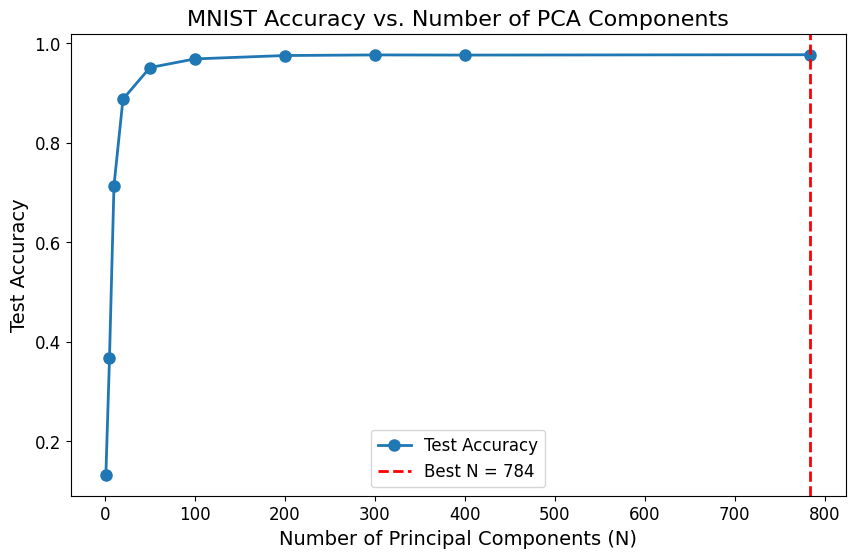

In [88]:
all_N_values = [1, 5, 10, 20, 50, 100, 200, 300, 400, 784]
best_N, accuracies = evaluate_pca_accuracy(original_model, test_images, test_labels, mu, vecs, all_N_values)
plot_pca_accuracy(all_N_values, accuracies, best_N)

Here the cell define another helper function, pca_train, which takes in a model, the training data, the mean vector mu, the eigenvectors vecs, and a chosen number of components N. It reconstructs the 60,000 training images from the top N principal components, returning those images in their 28×28 format. This function directly corresponds to the requirement of “making a new training dataset with the N-best PCA components” so that we can retrain the model on reduced representations of MNIST.

In [89]:
def pca_train(model, train_images, train_labels, mu, vecs, N):

    """
    Reconstructs the training images using the top N principal components.

    Args:
        model: The Keras model (not used in this function, but included for consistency).
        train_images: The original training images.
        train_labels: The training labels (not used in this function, but included for consistency).
        mu: The mean of the training data (pre-calculated).
        vecs: The eigenvectors (principal components) (pre-calculated).
        N: The number of principal components to use for reconstruction.

    Returns:
        train_images_reconstructed_reshaped: The reconstructed training images
                                             in their original shape (60000, 28, 28).
    """


  train_images_flat = train_images.reshape(60000, 784)

  train_images_centered = train_images_flat - mu

  train_images_pca = np.dot(train_images_centered, vecs[:, :N])

  train_images_reconstructed = np.dot(train_images_pca, vecs[:, :N].T) + mu

  train_images_reconstructed_reshaped = train_images_reconstructed.reshape((60000, 28, 28))

  return train_images_reconstructed_reshaped

In this cell N = 100, which is then used in pca_train to generate a reconstructed version of the entire training set using the top 100 components. The cell trains the original_model again, but this time on the reconstructed images rather than the originals. After 10 epochs, it stores this re-trained model in model_100. This step completes the instruction: “Now using the 100-best PCA components, make a new training dataset and retrain your neural network from step 1.

Next, it evaluates model_100 on those same reconstructed training images' to see how well it fits the data it was retrained on. We print the resulting test accuracy. Seeing a high accuracy here is expected because the model has just been trained on these reconstructed images, but this step still confirms the retraining has converged adequately.

In [90]:
N = 100
train_images_reconstructed_reshaped = pca_train(original_model, train_images, train_labels, mu, vecs, N)

original_model.fit(train_images_reconstructed_reshaped, train_labels,
                    batch_size=100, epochs=10, validation_split=0.1)

model_100 = original_model

test_loss, test_acc = model_100.evaluate(train_images_reconstructed_reshaped, train_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9811 - loss: 0.0579 - val_accuracy: 0.9777 - val_loss: 0.0742
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9871 - loss: 0.0420 - val_accuracy: 0.9818 - val_loss: 0.0652
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9891 - loss: 0.0349 - val_accuracy: 0.9822 - val_loss: 0.0664
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9911 - loss: 0.0307 - val_accuracy: 0.9822 - val_loss: 0.0672
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9918 - loss: 0.0270 - val_accuracy: 0.9808 - val_loss: 0.0700
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9927 - loss: 0.0244 - val_accuracy: 0.9817 - val_loss: 0.0673
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9941 - loss: 0.0223 - val_accuracy: 0.9805 - val_loss: 0.0715
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9950 - loss: 0.0193 - val_accuracy: 0.

Here the cell uses evaluate_pca_accuracy and plot_pca_accuracy, but now with model_100. This means it tests how the new model—trained on images reconstructed from 100 PCA components performs on test images reconstructed with different numbers of components. It aligns with “Repeat step 3 using your new neural network from 4.” The code again outputs which value of N gives the best accuracy and plots accuracy vs. N, potentially highlighting differences from the original model’s curve.



Best N: 400 with accuracy=0.9771


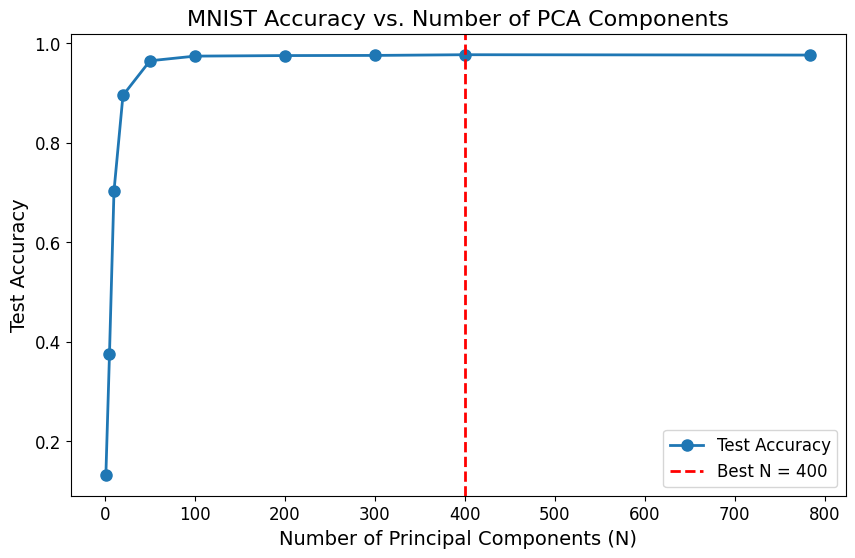

In [91]:
all_N_values = [1, 5, 10, 20, 50, 100, 200, 300, 400, 784]

best_N, accuracies = evaluate_pca_accuracy(model_100, test_images, test_labels, mu, vecs, all_N_values)
plot_pca_accuracy(all_N_values, accuracies, best_N)

Now the cell sets N = 20 and calls pca_train again, following the same pattern but with fewer components. Model_20 is the result of retraining the same original_model object on these 20-component reconstructions of the training set. "Repeat steps 4 and 5 using a network trained with the best 20 components" is the last prerequisite. To confirm that model_20 has learnt this reduced representation, it tests it on the 20-component training set and outputs the training accuracy. A strong score here suggests the model has adjusted effectively to lower-dimensional input, even if the training set consists of 20-component data once more.

In [92]:
N = 20
train_images_reconstructed_reshaped = pca_train(original_model, train_images, train_labels, mu, vecs, N)

original_model.fit(train_images_reconstructed_reshaped, train_labels,
                    batch_size=100, epochs=10, validation_split=0.1)

model_20 = original_model

test_loss, test_acc = model_20.evaluate(train_images_reconstructed_reshaped, train_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9431 - loss: 0.1833 - val_accuracy: 0.9643 - val_loss: 0.1177
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9639 - loss: 0.1150 - val_accuracy: 0.9698 - val_loss: 0.1050
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9689 - loss: 0.0963 - val_accuracy: 0.9695 - val_loss: 0.1105
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9724 - loss: 0.0880 - val_accuracy: 0.9708 - val_loss: 0.1062
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9741 - loss: 0.0817 - val_accuracy: 0.9730 - val_loss: 0.1051
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9746 - loss: 0.0780 - val_accuracy: 0.9717 - val_loss: 0.1062
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9750 - loss: 0.0786 - val_accuracy: 0.9705 - val_loss: 0.1086
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9774 - loss: 0.0730 - val_accuracy: 0.

Finally, this cell performs the now-familiar procedure of calling evaluate_pca_accuracy on model_20 across the same all_N_values, followed by plot_pca_accuracy. This demonstrates how the 20-component-trained model fares on test images reconstructed from various PCA dimensions. In doing so, it completes the requirement “Finally repeat steps 4 and 5 using a network trained with the best 20 components” and see the resulting accuracy behavior in the plot.

Best N: 300 with accuracy=0.9651


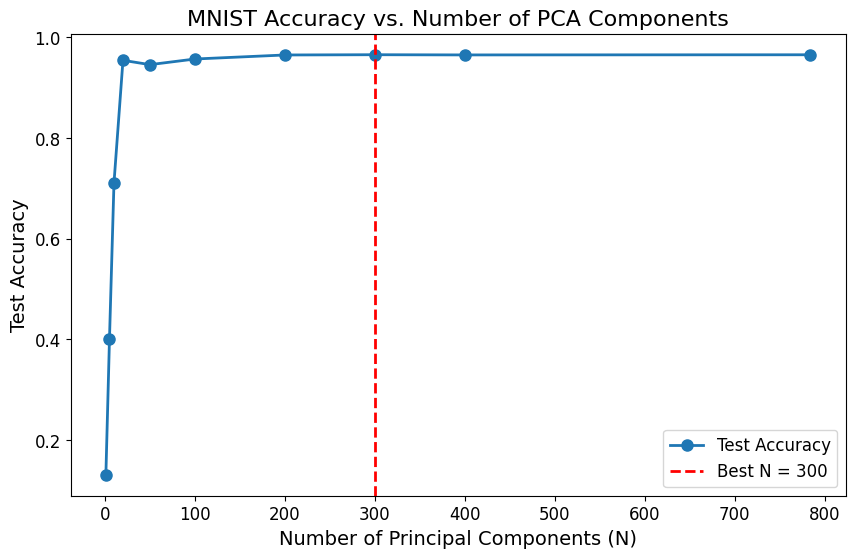

In [93]:
all_N_values = [1, 5, 10, 20, 50, 100, 200, 300, 400, 784]
best_N, accuracies = evaluate_pca_accuracy(model_20, test_images, test_labels, mu, vecs, all_N_values)
plot_pca_accuracy(all_N_values, accuracies, best_N)

**Summaries on the graphs:**

In each of these plots, you see test accuracy versus the number of principal components
N . The overall S‐shaped or quickly rising curve is typical of applying PCA to MNIST: when
N is very small, the model sees only a heavily compressed version of each image, so accuracy is poor. As
N increases, the reconstruction becomes more faithful, and the accuracy quickly climbs. Once you pass a certain threshold of components the model effectively sees nearly all the critical information, and accuracy plateaus close to the model’s maximum.

Early on, each additional principal component captures a large amount of variance in the images that helps the model classify better, so accuracy jumps quickly. Eventually, adding more components delivers increasingly marginal gains. By the time you reach a few hundred components, you have retained most of the information in the original images, so the accuracy flattens out, hovering near the performance of the full 784-dimensional dataset.


In the first two graphs, you see that the best
N is 784 and 300 for the original model and the model retrained with 100 components. That indicates that, for those particular trainings, the optimum point happens around those values of components. In the third plot, the best
N shifts to 300 for the model trained with only 20-component data—this can happen because each network has been trained on different data representations, and the sweet spot for how many components it needs to see at test time can shift. Essentially, once a model is retrained on very compressed data, it may require a slightly different number of components to reach its peak accuracy on a similarly reconstructed test set.


The shape affirms that MNIST digits can be compressed substantially while retaining enough information for high classification accuracy. The quick rise highlights how relatively few components  already encode most of the discriminatory features. The plateau beyond a certain
N means that increasing the dimensionality further barely changes the classification outcome, indicating that the added components mostly capture finer details that the network does not necessarily need.

**Conclusions:**

Overall, these plots illustrate how models trained and tested with PCA-reconstructed images behave: they perform poorly with too few components, peak at some mid-range
N, and then flatten as they approach the full 784-dimensional space. The best
N can vary slightly depending on how the network was trained , because the network’s internal weights adapt to whatever representations it sees during training.







